In [1]:
!pip install pandas scikit-learn seaborn

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import r_regression
from scipy.stats.contingency import association
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import chi2_contingency

In [3]:
# Impose a seed for reproducibility
random_seed = 421

In [4]:
csv_filename = 'mushrooms.csv'
df = pd.read_csv(csv_filename)

In [5]:
# Require all columns to be displayed on screen
pd.options.display.max_columns = df.shape[1]

In [6]:
# Use more explicit categorical value names
df['class'] = df['class'].replace({'e': 'edible', 'p': 'poisonous'})
df['cap-shape'] = df['cap-shape'].replace({'b': 'bell', 'c': 'conical', 'x': 'convex', 'f': 'flat', 'k': 'knobbed', 's': 'sunken'})
df['cap-surface'] = df['cap-surface'].replace({'f': 'fibrous', 'g': 'grooves', 'y': 'scaly', 's': 'smooth'})
df['cap-color'] = df['cap-color'].replace({'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'r': 'green', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'})
df['bruises'] = df['bruises'].replace({'t': 'Yes', 'f': 'No'})
df['odor'] = df['odor'].replace({'a': 'almond', 'l': 'anise', 'c': 'creosote', 'y': 'fishy', 'f': 'foul', 'm': 'musty', 'n': 'none', 'p': 'pungent', 's': 'spicy'})
df['gill-attachment'] = df['gill-attachment'].replace({'a': 'attached', 'd': 'descending', 'f': 'free', 'n': 'notched'})
df['gill-spacing'] = df['gill-spacing'].replace({'c': 'close', 'w': 'crowded', 'd': 'distant'})
df['gill-size'] = df['gill-size'].replace({'b': 'broad', 'n': 'narrow'})
df['gill-color'] = df['gill-color'].replace({'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'g': 'gray', 'r': 'green', 'o': 'orange', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'})
df['stalk-shape'] = df['stalk-shape'].replace({'e': 'enlarging', 't': 'tapering'})
df['stalk-root'] = df['stalk-root'].replace({'b': 'bulbous', 'c': 'club', 'u': 'cup', 'e': 'equal', 'z': 'rhizomorphs', 'r': 'rooted', '?': 'missing'})
df['stalk-surface-above-ring'] = df['stalk-surface-above-ring'].replace({'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'})
df['stalk-surface-below-ring'] = df['stalk-surface-below-ring'].replace({'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'})
df['stalk-color-above-ring'] = df['stalk-color-above-ring'].replace({'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'})
df['stalk-color-below-ring'] = df['stalk-color-below-ring'].replace({'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'r': 'green', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'})
df['veil-type'] = df['veil-type'].replace({'p': 'partial', 'u': 'universal'})
df['veil-color'] = df['veil-color'].replace({'n': 'brown', 'o': 'orange', 'w': 'white', 'y': 'yellow'})
df['ring-number'] = df['ring-number'].replace({'n': 'none', 'o': 'one', 't': 'two'})
df['ring-type'] = df['ring-type'].replace({'c': 'cobwebby', 'e': 'evanescent', 'f': 'flaring', 'l': 'large', 'n': 'none', 'p': 'pendant', 's': 'sheathing', 'z': 'zone'})
df['spore-print-color'] = df['spore-print-color'].replace({'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'r': 'green', 'o': 'orange', 'u': 'purple', 'w': 'white', 'y': 'yellow'})
df['population'] = df['population'].replace({'a': 'abundant', 'c': 'clustered', 'n': 'numerous', 's': 'scattered', 'v': 'several', 'y': 'solitary'})
df['habitat'] = df['habitat'].replace({'g': 'grasses', 'l': 'leaves', 'm': 'meadows', 'p': 'paths', 'u': 'urban', 'w': 'waste', 'd': 'woods'})

In [7]:
df.shape

(8124, 23)

In [8]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,edible,convex,scaly,brown,No,none,free,close,broad,buff,tapering,bulbous,smooth,smooth,white,white,partial,white,one,pendant,white,several,woods
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [9]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,Yes,pungent,free,close,narrow,black,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,Yes,almond,free,close,broad,black,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,Yes,anise,free,close,broad,brown,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,Yes,pungent,free,close,narrow,brown,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,edible,convex,smooth,gray,No,none,free,crowded,broad,black,tapering,equal,smooth,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses


In [10]:
# Indicate whether some features have only a single value
print(df.nunique()==1)

class                       False
cap-shape                   False
cap-surface                 False
cap-color                   False
bruises                     False
odor                        False
gill-attachment             False
gill-spacing                False
gill-size                   False
gill-color                  False
stalk-shape                 False
stalk-root                  False
stalk-surface-above-ring    False
stalk-surface-below-ring    False
stalk-color-above-ring      False
stalk-color-below-ring      False
veil-type                    True
veil-color                  False
ring-number                 False
ring-type                   False
spore-print-color           False
population                  False
habitat                     False
dtype: bool


In [11]:
# Drop features having only a single value
df = df.drop(['veil-type'], axis=1)
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,4,3,5,9,6,7
top,edible,convex,scaly,brown,No,none,free,close,broad,buff,tapering,bulbous,smooth,smooth,white,white,white,one,pendant,white,several,woods
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,7924,7488,3968,2388,4040,3148


In [12]:
def get_crosstab_chisquared_crammerv(data_1, data_2):
    crosstab = pd.crosstab(data_1, data_2)
    chi_squared = chi2_contingency(crosstab)[0]    
    cramer_v = np.sqrt((chi_squared / crosstab.sum().sum()) / (min(crosstab.shape) - 1))
    return crosstab, chi_squared, cramer_v

[Text(0, 0, 'class'),
 Text(0, 1, 'cap-shape'),
 Text(0, 2, 'cap-surface'),
 Text(0, 3, 'cap-color'),
 Text(0, 4, 'bruises'),
 Text(0, 5, 'odor'),
 Text(0, 6, 'gill-attachment'),
 Text(0, 7, 'gill-spacing'),
 Text(0, 8, 'gill-size'),
 Text(0, 9, 'gill-color'),
 Text(0, 10, 'stalk-shape'),
 Text(0, 11, 'stalk-root'),
 Text(0, 12, 'stalk-surface-above-ring'),
 Text(0, 13, 'stalk-surface-below-ring'),
 Text(0, 14, 'stalk-color-above-ring'),
 Text(0, 15, 'stalk-color-below-ring'),
 Text(0, 16, 'veil-color'),
 Text(0, 17, 'ring-number'),
 Text(0, 18, 'ring-type'),
 Text(0, 19, 'spore-print-color'),
 Text(0, 20, 'population'),
 Text(0, 21, 'habitat')]

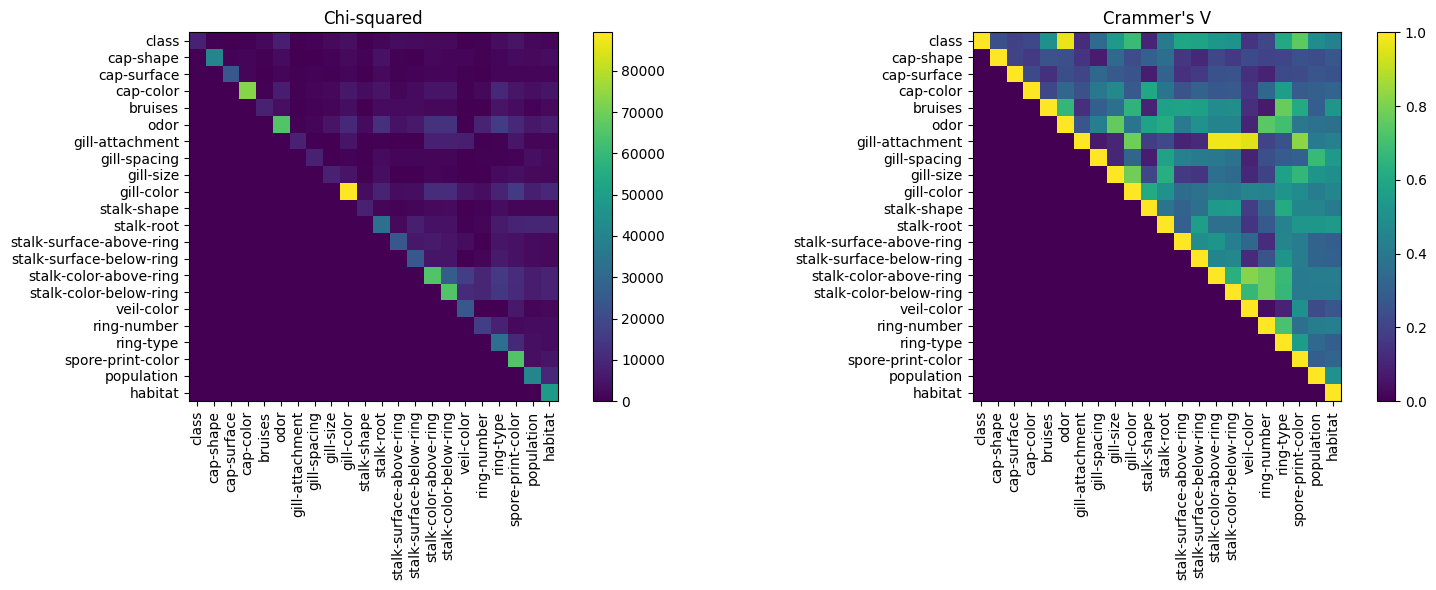

In [13]:
chi_squared = np.zeros((df.shape[1], df.shape[1]))
cramer_v = np.zeros((df.shape[1], df.shape[1]))

for index_a in range(df.shape[1]):
    for index_b in range(index_a, df.shape[1]):
        _, chi_squared[index_a, index_b], cramer_v[index_a, index_b] = get_crosstab_chisquared_crammerv(df.iloc[:, index_a], df.iloc[:, index_b])

fig, axs = plt.subplots(1, 2, figsize=(16, 6), tight_layout=True)

ax = axs[0]
fig.sca(ax)
plt.imshow(chi_squared)
plt.colorbar()
plt.title('Chi-squared')
ax.set_xticks(np.arange(df.shape[1]))
ax.set_yticks(np.arange(df.shape[1]))
ax.set_xticklabels(df.keys(), rotation='vertical')
ax.set_yticklabels(df.keys())

ax = axs[1]
fig.sca(ax)
plt.imshow(cramer_v)
plt.colorbar()
plt.title('Crammer\'s V')
ax.set_xticks(np.arange(df.shape[1]))
ax.set_yticks(np.arange(df.shape[1]))
ax.set_xticklabels(df.keys(), rotation='vertical')
ax.set_yticklabels(df.keys())

In [14]:
# Calculate the Cramer's V index for each feature against the target, and sort by decreasing value
cramer_v = np.zeros(df.shape[1] -1)
for index in range(df.shape[1] -1):
    _, _, cramer_v[index] = get_crosstab_chisquared_crammerv(df.iloc[:, 0], df.iloc[:, index +1])
descending_indices = np.flip(np.argsort(cramer_v))

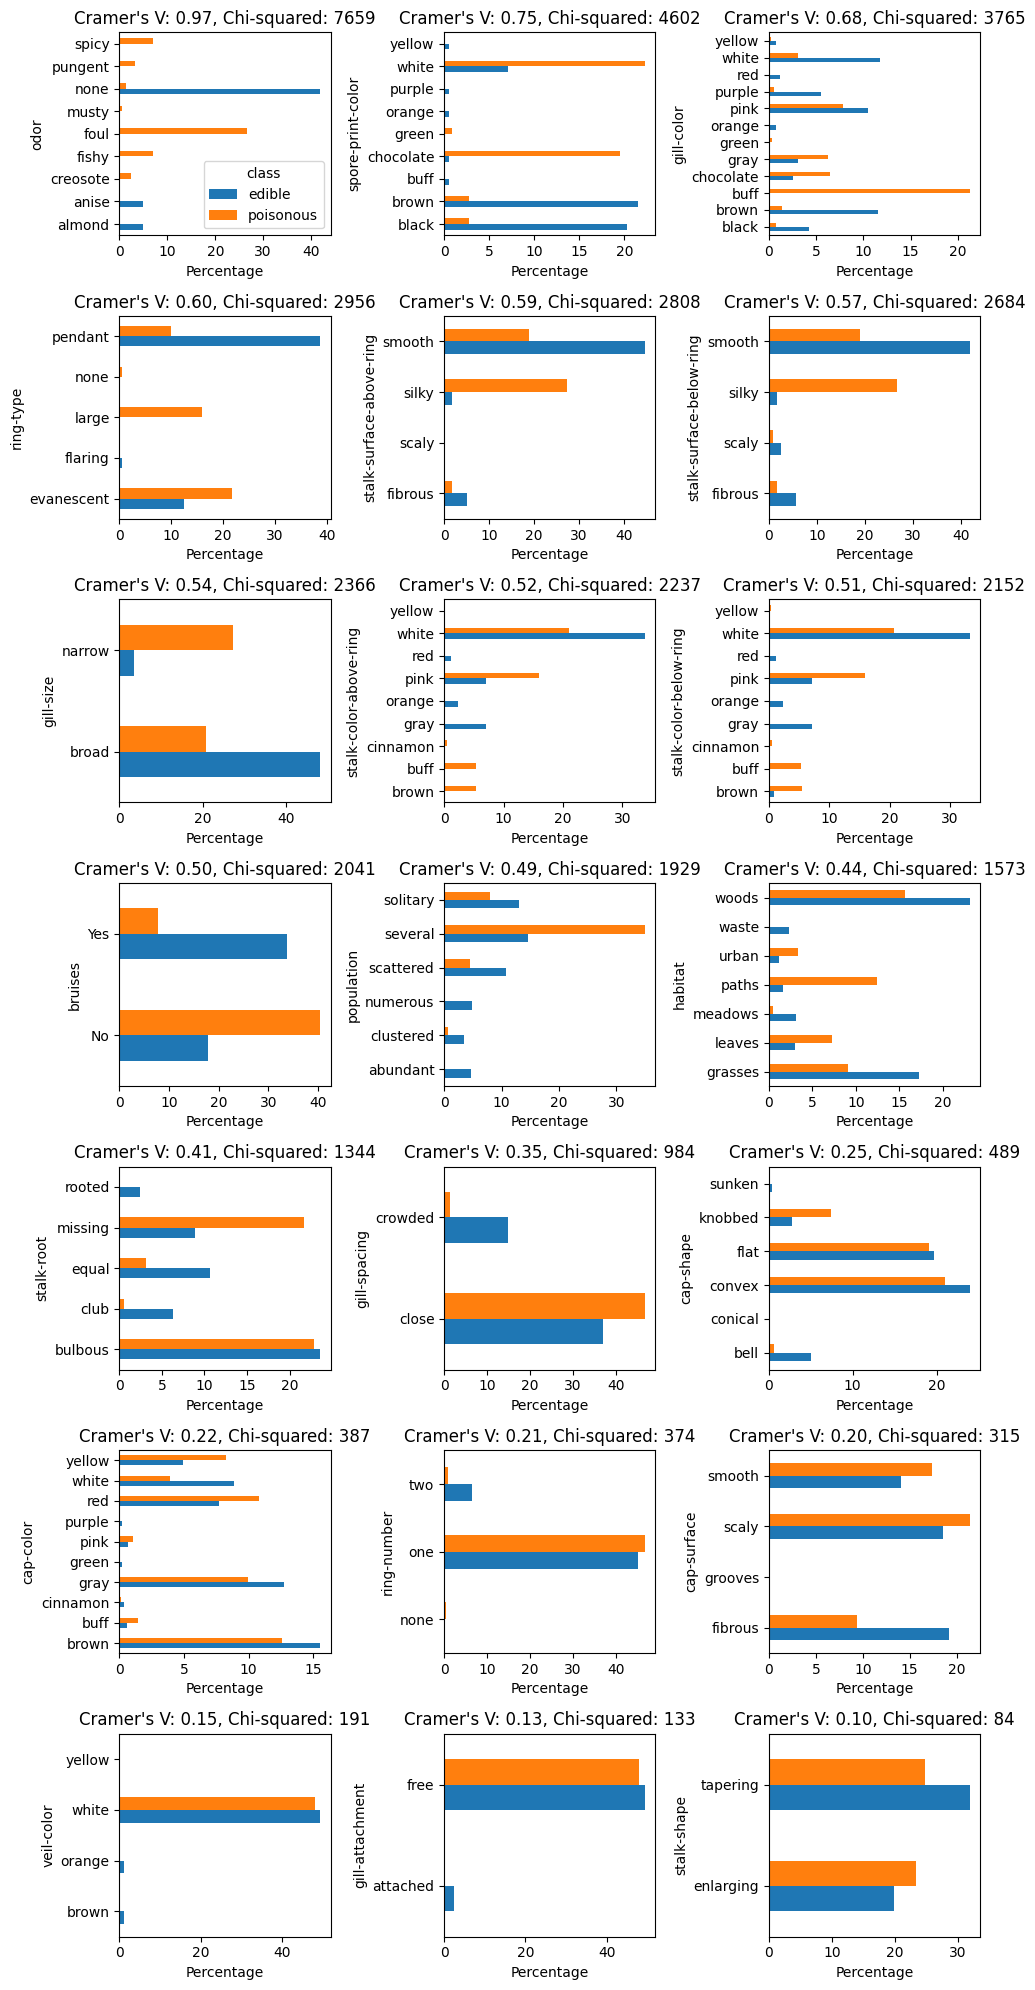

In [15]:
# Plot the crosstab of each feature, sorted by descending Cramer's V index
fig, axs = plt.subplots(7, 3, figsize=(10, 20), tight_layout=True)
axs = axs.ravel()
for index in range(21):
    descending_index = descending_indices[index] +1
    crosstab, chi_squared, cramer_v = get_crosstab_chisquared_crammerv(df.iloc[:, 0], df.iloc[:, descending_index])
    barplot = (100*crosstab/df.shape[0]).T.plot.barh(ax=axs[index], legend=index==0)    
    axs[index].set_xlabel('Percentage')
    axs[index].set_title('Cramer\'s V: {:.2f}, Chi-squared: {}'.format(cramer_v, int(chi_squared)))

In [16]:
# Print out features having at least one zero-value for either the 'edible' or 'poisonous' class
for index in range(df.shape[1] -1):
    crosstab, _, _ = get_crosstab_chisquared_crammerv(df.iloc[:, 0], df.iloc[:, index +1])
    print(crosstab.eq(0))

cap-shape   bell  conical  convex   flat  knobbed  sunken
class                                                    
edible     False     True   False  False    False   False
poisonous  False    False   False  False    False    True
cap-surface  fibrous  grooves  scaly  smooth
class                                       
edible         False     True  False   False
poisonous      False    False  False   False
cap-color  brown   buff  cinnamon   gray  green   pink  purple    red  white  \
class                                                                          
edible     False  False     False  False  False  False   False  False  False   
poisonous  False  False     False  False   True  False    True  False  False   

cap-color  yellow  
class              
edible      False  
poisonous   False  
bruises       No    Yes
class                  
edible     False  False
poisonous  False  False
odor       almond  anise  creosote  fishy   foul  musty   none  pungent  spicy
class       

In [24]:
# Regroup features that have at least two zero-values for either the 'edible' or 'poisonous' class
curated_df = df.copy()
curated_df['cap-color'] = curated_df['cap-color'].replace(['green', 'purple'], 'green_purple')
curated_df['odor'] = curated_df['odor'].replace(['almond', 'anise'], 'almond_anise')
curated_df['odor'] = curated_df['odor'].replace(['creosote', 'fishy', 'foul', 'musty', 'pungent', 'spicy'], 'foul_et_al')
curated_df['gill-color'] = curated_df['gill-color'].replace(['buff', 'green'], 'buff_green')
curated_df['gill-color'] = curated_df['gill-color'].replace(['red', 'orange'], 'red_orange')
curated_df['stalk-color-above-ring'] = curated_df['stalk-color-above-ring'].replace(['buff', 'cinnamon', 'yellow'], 'buff_cinnamon_yellow')
curated_df['stalk-color-above-ring'] = curated_df['stalk-color-above-ring'].replace(['gray', 'orange', 'red'], 'gray_orange_red')
curated_df['stalk-color-below-ring'] = curated_df['stalk-color-below-ring'].replace(['buff', 'cinnamon', 'yellow'], 'buff_cinnamon_yellow')
curated_df['stalk-color-below-ring'] = curated_df['stalk-color-below-ring'].replace(['gray', 'orange', 'red'], 'gray_orange_red')
curated_df['veil-color'] = curated_df['veil-color'].replace(['brown', 'orange'], 'brown_orange')
curated_df['ring-type'] = curated_df['ring-type'].replace(['large', 'none'], 'large_none')
curated_df['spore-print-color'] = curated_df['spore-print-color'].replace(['buff', 'orange', 'purple', 'yellow'], 'buff_orange_purple_yellow')
curated_df['population'] = curated_df['population'].replace(['abundant', 'numerous'], 'abundant_numerous')

for index in range(curated_df.shape[1] -1):
    crosstab, _, _ = get_crosstab_chisquared_crammerv(curated_df.iloc[:, 0], curated_df.iloc[:, index +1])
    print(crosstab.eq(0))

cap-shape   bell  conical  convex   flat  knobbed  sunken
class                                                    
edible     False     True   False  False    False   False
poisonous  False    False   False  False    False    True
cap-surface  fibrous  grooves  scaly  smooth
class                                       
edible         False     True  False   False
poisonous      False    False  False   False
cap-color  brown   buff  cinnamon   gray  green_purple   pink    red  white  \
class                                                                         
edible     False  False     False  False         False  False  False  False   
poisonous  False  False     False  False          True  False  False  False   

cap-color  yellow  
class              
edible      False  
poisonous   False  
bruises       No    Yes
class                  
edible     False  False
poisonous  False  False
odor       almond_anise  foul_et_al   none
class                                     
edible   

[ 4 18  8 17 11 12  7 13 14  3 19 20 10  6  0  2 16  1 15  5  9]


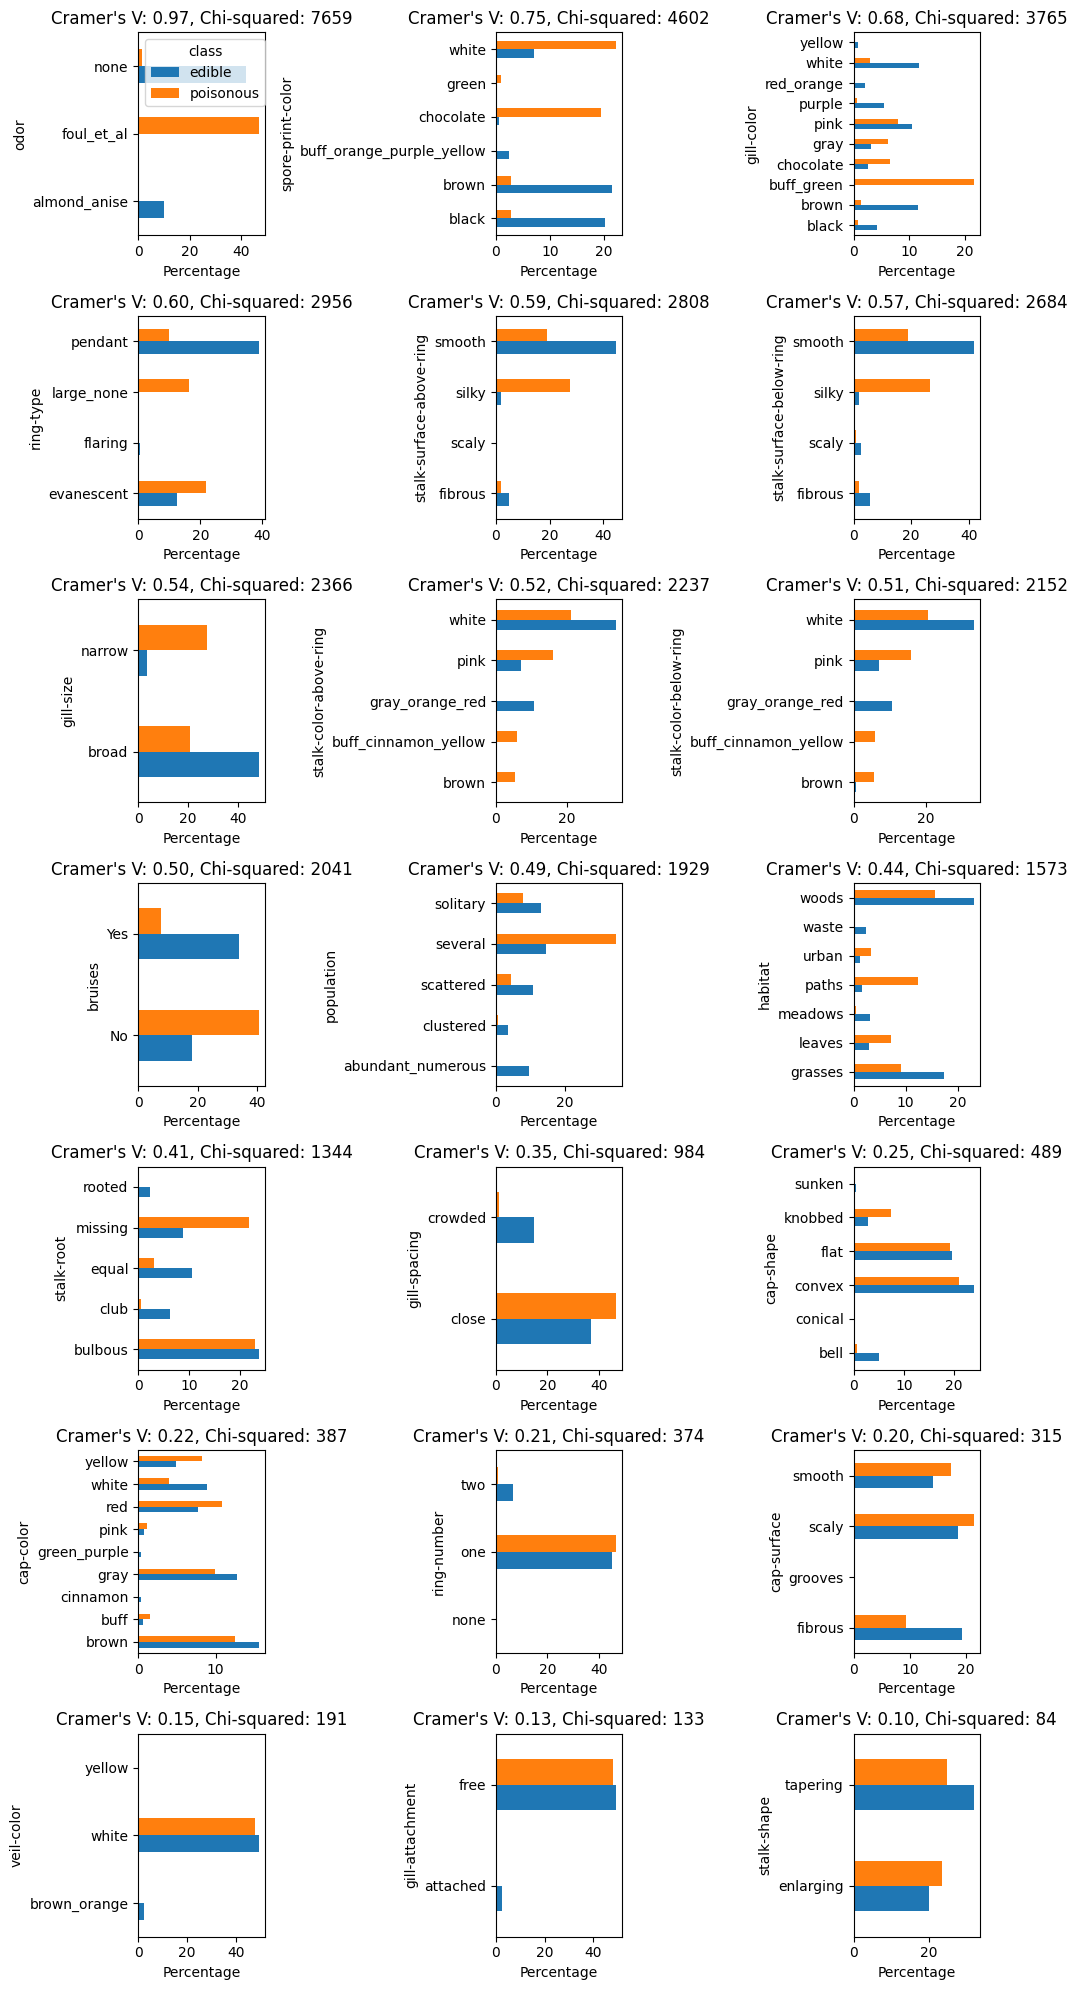

In [23]:
cramer_v = np.zeros(df.shape[1] -1)
for index in range(df.shape[1] -1):
    _, _, cramer_v[index] = get_crosstab_chisquared_crammerv(df.iloc[:, 0], df.iloc[:, index +1])
descending_indices = np.flip(np.argsort(cramer_v))

fig, axs = plt.subplots(7, 3, figsize=(10, 20), tight_layout=True)
axs = axs.ravel()
for index in range(21):
    descending_index = descending_indices[index] +1
    crosstab, chi_squared, cramer_v = get_crosstab_chisquared_crammerv(curated_df.iloc[:, 0], curated_df.iloc[:, descending_index])
    barplot = (100*crosstab/curated_df.shape[0]).T.plot.barh(ax=axs[index], legend=index==0)    
    axs[index].set_xlabel('Percentage')
    axs[index].set_title('Cramer\'s V: {:.2f}, Chi-squared: {}'.format(cramer_v, int(chi_squared)))

In [40]:
X = df.drop('class', axis=1)
y = df['class']

y[y=='p'] = 0 # Poisonous
y[y=='e'] = 1 # Edible
y = y.astype(int)

In [43]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[   0    4    5 ... 8121 8122 8123]
  Test:  index=[   1    2    3 ... 8090 8100 8116]
Fold 1:
  Train: index=[   0    1    2 ... 8120 8121 8122]
  Test:  index=[  11   16   18 ... 8111 8115 8123]
Fold 2:
  Train: index=[   0    1    2 ... 8121 8122 8123]
  Test:  index=[   4    5    7 ... 8117 8118 8119]
Fold 3:
  Train: index=[   1    2    3 ... 8121 8122 8123]
  Test:  index=[   0   17   21 ... 8113 8114 8120]
Fold 4:
  Train: index=[   0    1    2 ... 8119 8120 8123]
  Test:  index=[   9   15   24 ... 8112 8121 8122]
